# Домашнее задание №3

Задание присылать на почту **(aleksartmonov@gmail.com)** в формах *.ipynb* и отрендеренный результат в *.html*

В теме письма указать **HSE2019 HW3 <Фамилия Имя>**

soft deadline: 24.02.2019T23:59:00+0300

hard deadline: 03.03.2019T23:59:00+0300


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/My\ Drive/tmp/hw3 -r ./
%cd hw3

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
/content/hw3


In [1]:
import numpy as np
import cv2
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('default')

In [2]:
def show_bgr(ax, img, size=3):
    ax.set_axis_off()
    ax.imshow(img)

def show_gray(ax, img, size=3):
    ax.set_axis_off()
    ax.imshow(img, cmap='gray')

def show(imgs, size=5):
    nrows, ncols = len(imgs), max(len(row) for row in imgs)
    _, axs = plt.subplots(nrows, ncols, figsize=(ncols * size, nrows * size), squeeze=False)
    for axs_row, imgs_row in zip(axs, imgs):
        for ax, img in zip(axs_row, imgs_row):
            if len(img.shape) == 3:
                show_bgr(ax, img)
            else:
                show_gray(ax, img)

lena = cv2.imread('lena.jpg')

## Legacy классификация

**Задане 1 (10 баллов)**

Реализуйте функцию, которая строит банк фильтров Габора.
Реализуйте интерактивный инструмент, в котором с помощью 2-х ползунков, один из которых отвечает за угол, другой за масштаб для фильтров из банка, можно выбрать конкретный фильтр и на экране отобразятся:
- Фильтр в пространственной области
- Фильтр в частотном пространстве
- Результат применения этого фильтра к какому-нибудь изображению.

In [3]:
def gabour_bank(size, phi_bins, scale_bins, max_scale, min_scale, sigma=4.):
    """
    Parameters:
    size (tuple|int): Size or radius of filters.
    phi_bins (int): Number of angle beens of bank
    scale_bins (int): Number of scales betwwen max_scale and min_scale
    max_scale (float): Max frequency covered by bank
    min_scale (float): Min frequency covered by bank
    Returns:
    list: a list of filters
    """
    xs, ys = [], []
    if isinstance(size, tuple):
        xs = np.arange(size[0] // 2. * -1., size[0] // 2. + 1.) / (size[0] // 2.)
        ys = np.arange(size[1] // 2. * -1., size[1] // 2. + 1.) / (size[1] // 2.)
    else:
        xs = np.arange(size // 2. * -1., size // 2. + 1.) / (size // 2.)
        ys = np.arange(size // 2. * -1., size // 2. + 1.) / (size // 2.)
    len_x, len_y = len(xs), len(ys)
    phi_bins = np.linspace(start=0, stop=2 * np.pi, num=phi_bins + 1)
    scale_bins = np.linspace(start=min_scale, stop=max_scale, num=scale_bins)
    
    res_real = []
    res_imag = []
    for phi in phi_bins:
        row_real = []
        row_imag = []
        for scale in scale_bins:
            lmbd = 1. / scale
            sigma = 0.5 / scale
            vals_real = np.empty((len_y, len_x), dtype=np.float32)
            vals_imag = np.empty((len_y, len_x), dtype=np.float32)
            for i in range(len_y):
                y = ys[i]
                for j in range(len_x):
                    x = xs[j]
                    x_new = x * np.cos(phi) + y * np.sin(phi)
                    y_new = -x * np.sin(phi) + y * np.cos(phi)
                    vals_real[i, j] = np.exp(-1 * (x_new ** 2 + y_new ** 2) / 2. / sigma ** 2) * np.cos(2. * np.pi * x_new / lmbd)
                    vals_imag[i, j] = np.exp(-1 * (x_new ** 2 + y_new ** 2) / 2. / sigma ** 2) * np.sin(2. * np.pi * x_new / lmbd)
            row_real.append(vals_real)
            row_imag.append(vals_imag)
        res_real.append(row_real)
        res_imag.append(row_imag)
    return np.asarray(res_real), np.asarray(res_imag)

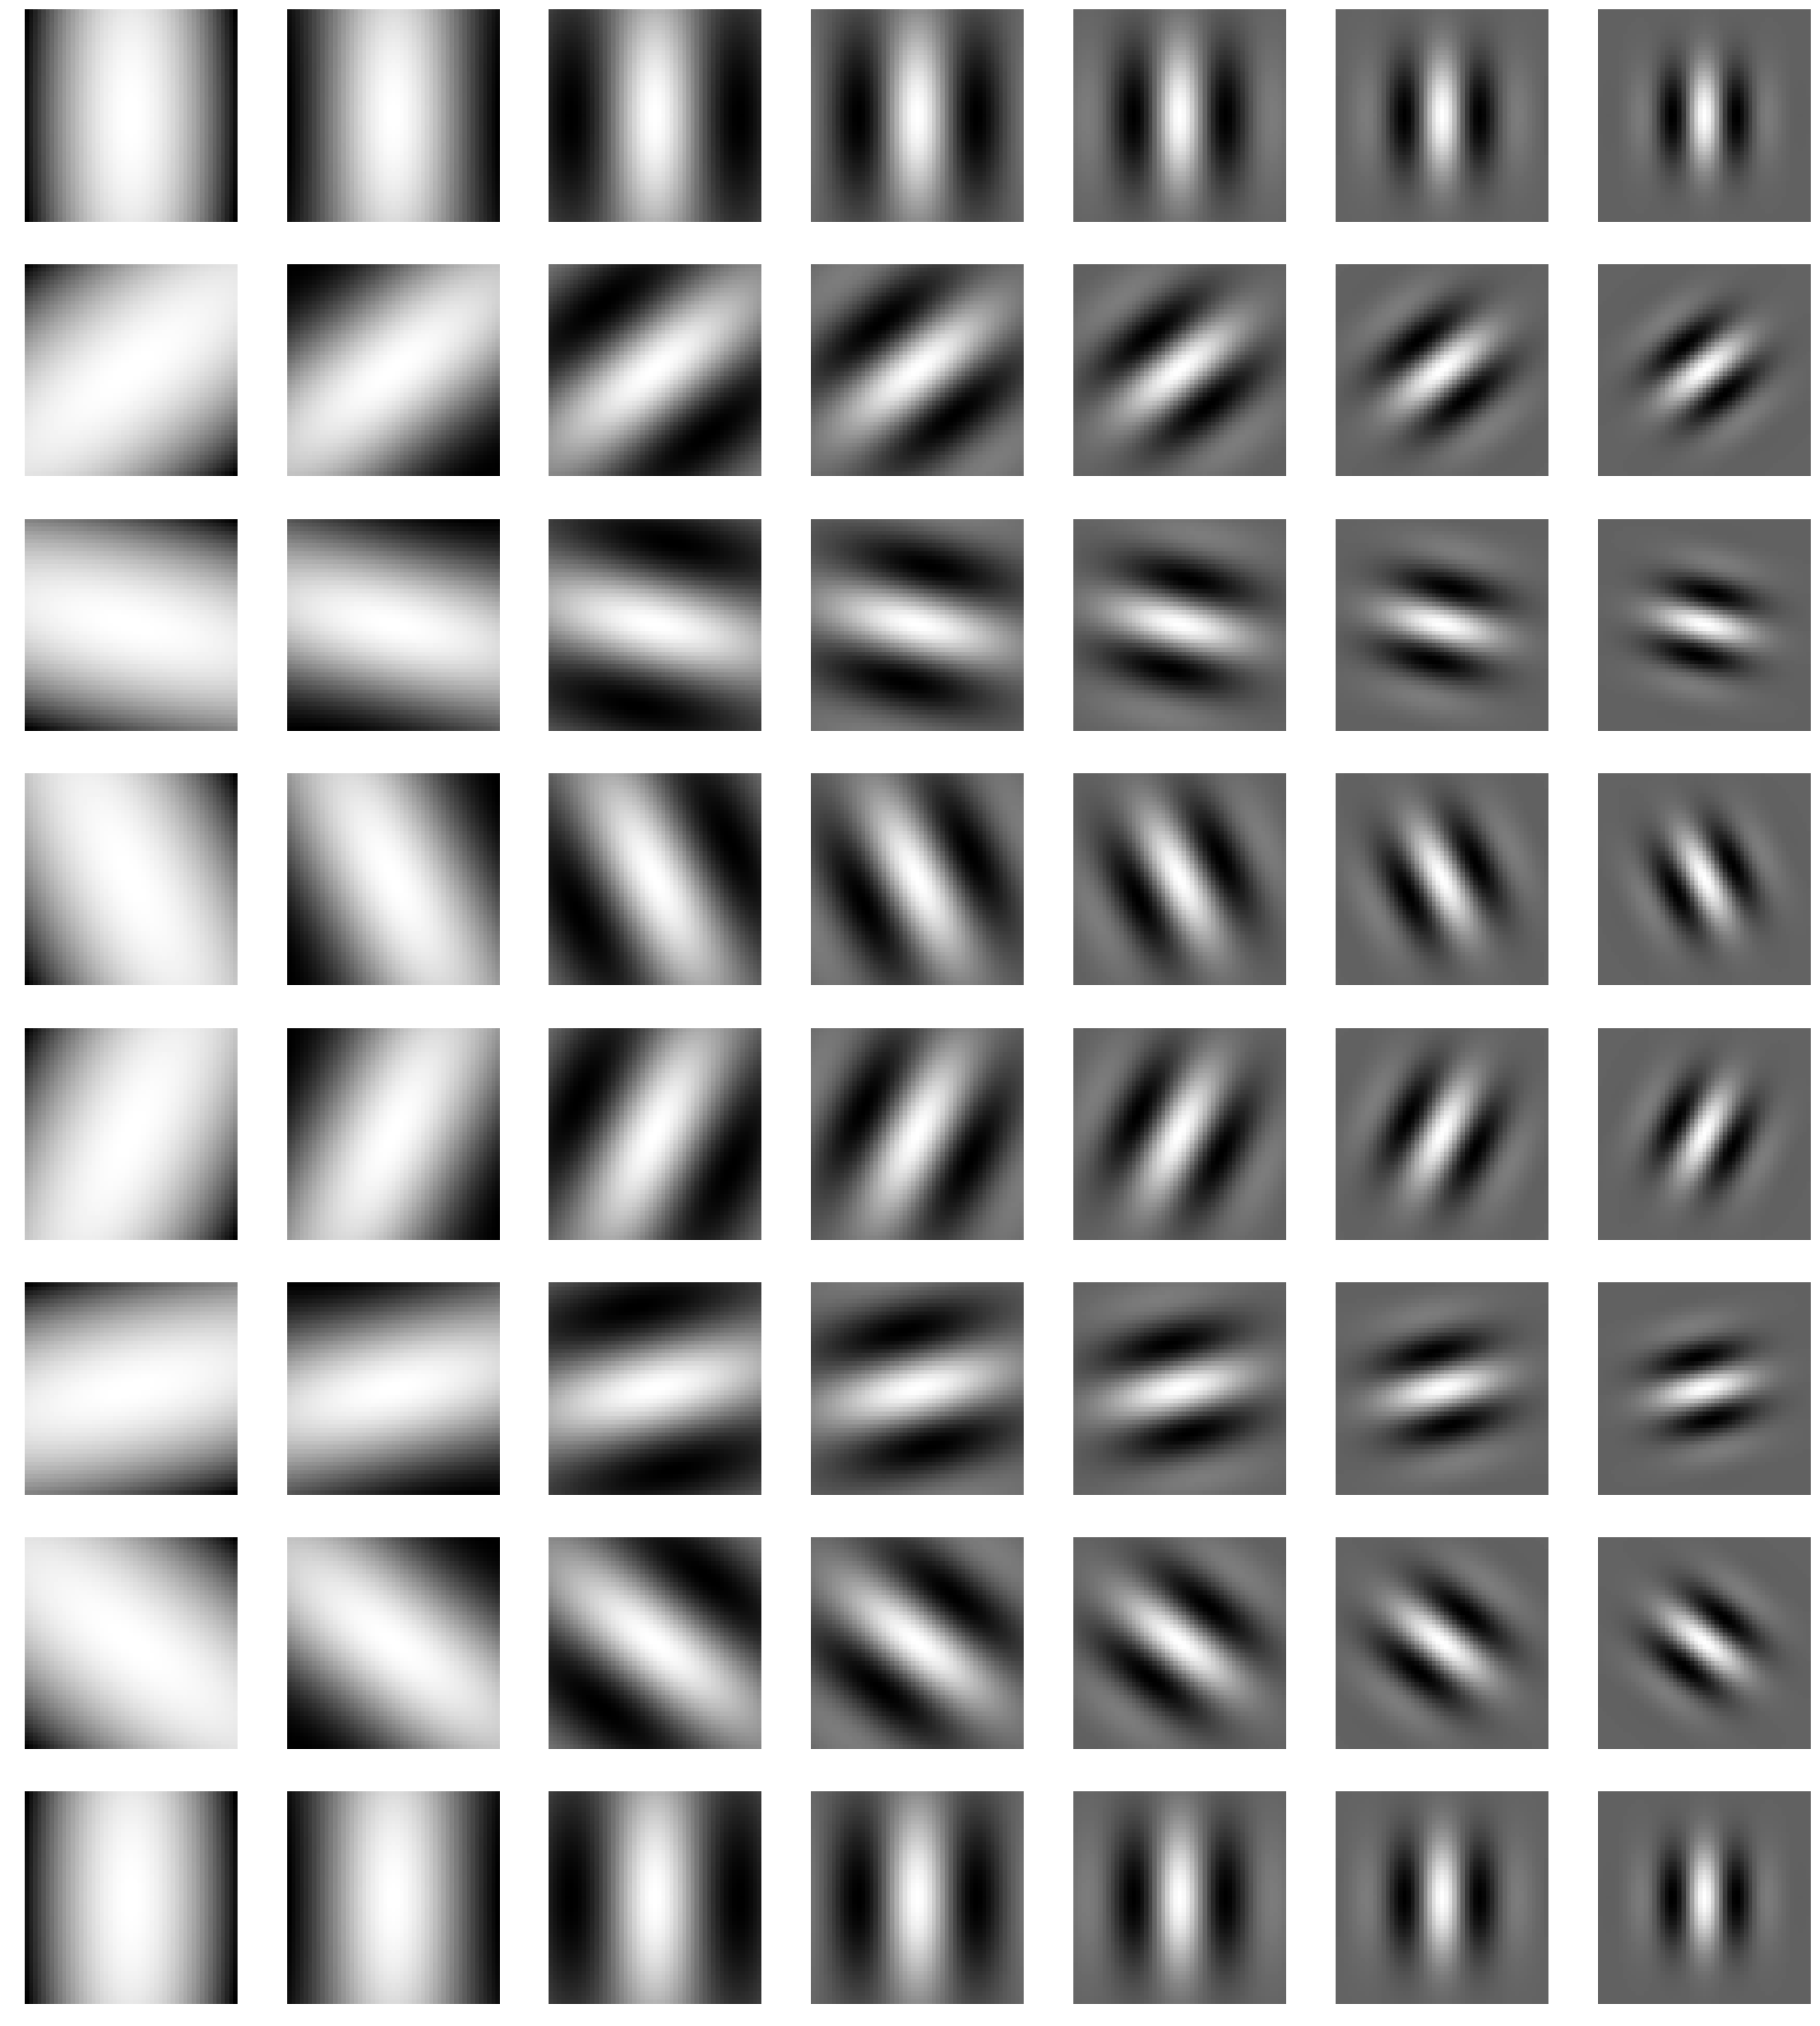

In [4]:
gab_real, gab_imag = gabour_bank(50, 7, 7, 1.5, 0.1)
show(gab_real)

In [5]:
import ipywidgets as wg


def use_gabor(img, gab):
    return cv2.filter2D(img, -1, gab.imag).astype(np.float32)


def fourier(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return np.log(np.abs(fshift))

gab_real, gab_imag = gabour_bank(50, len(np.arange(0, np.pi * 2, step=np.pi / 10.)),
                                 len(np.arange(0.1, 2., step=0.1)) + 1, 2., 0.1)
lena_gray = cv2.cvtColor(lena, cv2.COLOR_BGR2GRAY)

def show_gabor(phi, scale):
    real = gab_real[int(phi // (np.pi / 10.))][int(scale // 0.1) - 1]
    imag = gab_imag[int(phi // (np.pi / 10.))][int(scale // 0.1) - 1]
    gab = np.empty(real.shape, dtype=np.complex)
    gab.real = real.copy()
    gab.imag = imag.copy()
    show([[real, imag], [fourier(real), fourier(imag)]])
    show([[use_gabor(lena_gray, gab)]])

wg.interact(lambda phi, scale: show_gabor(phi, scale),
                 phi = wg.FloatSlider(value=np.pi / 10., min=0, max=np.pi * 2, step=np.pi / 10., continuous_update=False),
                 scale = wg.FloatSlider(value=0.1, min=0.1, max=2., step=0.1, continuous_update=False))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMzE0MTU5MjY1MzU4OTc5MywgY29udGludW91c191cGRhdGU9RmFsc2UsIGRlc2NyaXB0aW9uPXUncGhpJywgbWF4PTbigKY=


<function __main__.<lambda>>

In [7]:
print(gab_real.shape)

(21, 20, 51, 51)


**Задание 2 (15 баллов)** 

Постройте мешок визульных слов на основе SIFT дескртипторов для датасета из третьего задания. Для этого для каждой картинки примените функцию, которая извлекает sift keypoints с дексрипторами, для каждой картинки ограничьтесь, например, сотней. Проведите кластеризацию на N(~30) классов, для каждого кластра отбразите в ряду 5 ближайших к нему участков изображений, в соответствии с масштабом keypoint-а. отобразите N таких строк.

In [0]:
!unzip -q train.zip
!unzip -q test.zip

In [0]:
!pip install opencv-contrib-python==3.2.0.7

In [12]:
import os
imgs_train = []
files_train = []
for img in os.listdir("train"):
    files_train.append(img)
files_train.sort()
for img in files_train:
    imgs_train.append(cv2.imread("train/" + img))

In [9]:
import os
imgs_test = []
files_test = []
for img in os.listdir("test"):
    files_test.append(img)
files_test.sort()
for img in files_test:
    imgs_test.append(cv2.imread("test/" + img))

In [0]:
labels_file = open("train.csv", 'r')
labels_file.readline()
train_labels = [0] * len(files_train)
for line in labels_file:
    f, c = line.split(",")
    train_labels[files_train.index(f)] = int(c)

In [10]:
import math
from sklearn.cluster import KMeans

def get_descs_keys(imgs, nfeatures=100):
    sift = cv2.xfeatures2d.SIFT_create(nfeatures=nfeatures)
    descs, keypoints, counts, imps = [], [], [], []
    for idx in range(len(imgs)):
        img = imgs[idx]
        h, w, _ = img.shape
        keys, descs_new = sift.detectAndCompute(img, None)
        if descs_new is None:
            counts.append(0)
            imps.append([])
            continue
        descs.extend(descs_new)
        counts.append(len(descs_new))
        tmp = []
        for key in keys:
            tmp.append(key.response)
            half, x, y = key.size / 2, key.pt[0], key.pt[1]
            tx, ty = max(int(x - half), 0), max(int(y - half), 0)
            bx, by = min(int(x + half) + 1, int(w)), min(int(y + half) + 1, int(h))
            rotation = cv2.getRotationMatrix2D(key.pt, key.angle, 1)
            img_new = cv2.warpAffine(img, rotation, (w, h))
            keypoints.append(img_new[ty:by, tx:bx, :])
        imps.append(tmp)
    return descs, keypoints, counts, imps

In [14]:
descs_train, keys_train, counts, imps = get_descs_keys(imgs_train)

In [0]:
k = 30
kmeans = KMeans(k)
descs = kmeans.fit_transform(descs_train)

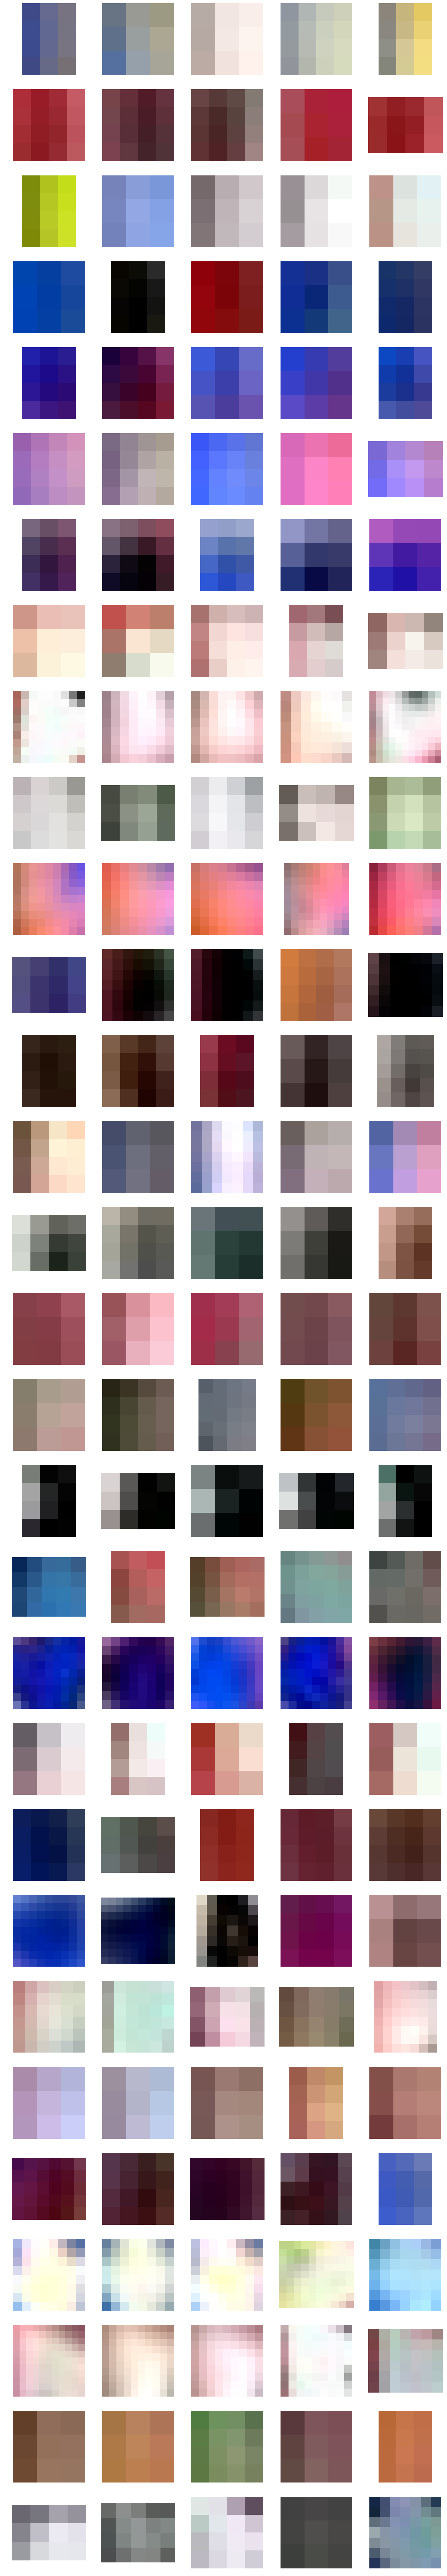

In [0]:
top = 5
res = []
for i in range(k):
    tmp = np.asarray(descs[:, i])
    idxs = tmp.argsort()[:top]
    tmp = []
    for idx in idxs:
        tmp.append(cv2.cvtColor(keys_train[idx], cv2.COLOR_BGR2RGB))
    res.append(tmp)
show(res)

**Задание 3 (20 баллов)**

[КОНКУРС](https://youtu.be/8GGWedu77SA?t=3388)

В этом задании вам придется проявить изобретательность. Используйте банки фильтов, мешки визуальных слов и гистрограммы для достижения максимального скора. [Настоящая ссылка на конкурс](https://www.kaggle.com/t/4d1c3bf048d44a0089e7b0ab75d01557). В этом задании баллы будут распределяться согласно тому, как далеко вы продвинулись на лидерборде. **Важное условие**, весь ваш код положите в этот ноутбук, в нем не должно быть нейросетей =) Только legacy только *hard core*

Чистые пиксели: 0.7
Максимум с габором: 0.6
Максимум с мешком слов: 0.55
Максимум с гистограммами: 0.22

In [0]:
fout = open("res.csv", 'w')

In [0]:
def filter_descs(descs, labels, count, imps):
    filtered, labs = [], []
    i = 0
    flat_imps = []
    for imp in imps:
        flat_imps.extend(imp)
    aver_imp = np.average(np.asarray(flat_imps))
    for id, n in enumerate(counts):
        lab = labels[id]
        if n == 0:
            continue
        for j in range(i, i + n):
            if flat_imps[j] > 0.03:
                filtered.append(descs[j])
                labs.append(lab)
        i = i + n
    return filtered, labs


In [47]:
filteresd_descs_train, desc_train_labels = filter_descs(descs_train, train_labels, counts, imps)
print(len(filteresd_descs_train))

91722


In [48]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(filteresd_descs_train, desc_train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
descs_test, _, counts, imps = get_descs_keys(imgs_test)
test_labels = {}
for i in range(len(counts)):
    test_labels[i] = []
i = 0
for id, n in enumerate(counts):
    if n == 0:
        continue
    for j in range(i, i + n):
        if imps[id][j - i] > 0.05:
            test_labels[id].append(clf.predict([descs_test[j]]))
    i = i + n

In [0]:
max_lab = max(train_labels)
res_vis = []
for id in test_labels:
    tmp = []
    for val in test_labels[id]:
        tmp.append(val[0])
    if len(tmp) != 0:
        res_vis.append(max(tmp, key=tmp.count))
    else:
        res_vis.append(np.random.randint(max_lab + 1))    

In [0]:
print("filename,class_number")
for id, lab in enumerate(res_vis):
    print(files_test[id] + "," + str(lab))

Gabor


In [0]:
from scipy import ndimage as ndi

def compute_vals(img, gabs_real, gabs_imag):
    '''img_new = (img - img.mean()) / img.std()
    vals = []
    for i, gab_row in enumerate(gabs_imag):
        for j, gab in enumerate(gab_row):
            filtered = np.sqrt(cv2.filter2D(img_new, -1, gab).astype(np.float32)**2 +
                               cv2.filter2D(img_new, -1, gabs_real[i, j]).astype(np.float32)**2)
                       #np.sqrt(ndi.convolve(img_new, gab, mode='wrap')**2 +
                       #ndi.convolve(img_new, gabs_imag[k], mode='wrap')**2)
            vals.append((filtered.mean(), filtered.var()))'''
    vals = []
    img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    for i, gab_row in enumerate(gabs_imag):
        for j, gab in enumerate(gab_row):
            filtered = np.sqrt(cv2.filter2D(img_new, -1, gab).astype(np.float32)**2 +
                               cv2.filter2D(img_new, -1, gabs_real[i, j]).astype(np.float32)**2)
            vals.append(filtered.flatten())
    return vals


def find_closest(vals, anchors):
    min_err = np.inf
    min_i = None
    for anc in anchors:
        err = np.sum((vals - anc)**2)
        if err < min_err:
            min_err = err
            min_i = i
    return min_i


def find_closest_mv(v_id, vals, anchors):
    min_err = np.inf
    min_i = None
    for id, anc in enumerate(anchors):
        if v_id % gab_num != id % gab_num:
            continue
        err = (vals.mean() - anc[0]) ** 2 + (vals.var() - anc[1]) ** 2
        if err < min_err:
            min_err = err
            min_i = i
    return min_i

In [0]:
anchors = []
train_labels_gab = []
print("train")
h, w, _ = imgs_train[0].shape
ex = 4
gab_num = gab_real.shape[0] * gab_real.shape[1]
for i, img in enumerate(imgs_train):
    if i % 1000 == 0:
        print(i)
    vals = compute_vals(img[4:h-4, 4:w-4], gab_real, gab_imag)
    train_labels_gab.extend([train_labels[i]] * gab_num)
    anchors.extend(vals)

In [22]:
print(len(train_labels_gab))

508640


In [41]:
from sklearn.ensemble import RandomForestClassifier

clf_gabs = [RandomForestClassifier()] * gab_num
anchors_div = []
for i in range(gab_num):
    print(i)
    anchors_div.append([])
    for id in range(i, len(anchors), gab_num):
        anchors_div[-1].append(anchors[id])
    clf_gabs[i].fit(anchors_div[-1], train_labels)

0


/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [0]:
anchors_test = []
for i, img in enumerate(imgs_test):
    if i % 1000 == 0:
        print(i)
    vals = compute_vals(img[4:h-4, 4:w-4], gab_real, gab_imag)
    anchors_test.extend(vals)

In [0]:
test_labels = {}
for i in range(len(imgs_test)):
    test_labels[i] = []
for i, anc in enumerate(anchors_test):
    test_labels[i // gab_num].append(clf_gabs[i % gab_num].predict([anc]))

In [0]:
max_lab = max(train_labels)
res_gab = []
for id in test_labels:
    tmp = []
    for val in test_labels[id]:
        tmp.append(val[0])
    if len(tmp) != 0:
        res_gab.append(max(tmp, key=tmp.count))
    else:
        res_gab.append(np.random.randint(max_lab + 1)) 

In [47]:
print("filename,class_number")
for id, lab in enumerate(res_gab):
    print(files_test[id] + "," + str(lab))

filename,class_number
000000.png,48
000001.png,48
000002.png,18
000003.png,18
000004.png,18
000005.png,55
000006.png,48
000007.png,19
000008.png,18
000009.png,9
000010.png,18
000011.png,48
000012.png,55
000013.png,9
000014.png,48
000015.png,48
000016.png,55
000017.png,18
000018.png,9
000019.png,55
000020.png,64
000021.png,18
000022.png,18
000023.png,18
000024.png,18
000025.png,48
000026.png,18
000027.png,55
000028.png,55
000029.png,29
000030.png,18
000031.png,48
000032.png,9
000033.png,18
000034.png,9
000035.png,48
000036.png,18
000037.png,48
000038.png,48
000039.png,18
000040.png,48
000041.png,19
000042.png,48
000043.png,18
000044.png,9
000045.png,48
000046.png,48
000047.png,18
000048.png,55
000049.png,55
000050.png,18
000051.png,9
000052.png,8
000053.png,9
000054.png,48
000055.png,55
000056.png,9
000057.png,18
000058.png,9
000059.png,2
000060.png,55
000061.png,48
000062.png,55
000063.png,18
000064.png,29
000065.png,18
000066.png,55
000067.png,18
000068.png,18
000069.png,18
000070.png

In [38]:
mv_anchors = [[anc.mean(), anc.var()] for anc in anchors]
test_labels = {}
for i in range(len(imgs_test)):
    test_labels[i] = []
for i, anc in enumerate(anchors_test):
    if i % 1000 == 0:
        print(i)
    test_labels[i // gab_num].append(find_closest_mv(i, anc, mv_anchors) // gab_num)
max_lab = max(train_labels)
res_gab = []
for id in test_labels:
    tmp = []
    for val in test_labels[id]:
        tmp.append(val[0])
    if len(tmp) != 0:
        res_gab.append(max(tmp, key=tmp.count))
    else:
        res_gab.append(np.random.randint(max_lab + 1)) 
print("filename,class_number")
for id, lab in enumerate(res_gab):
    print(files_test[id] + "," + str(lab))

0


KeyboardInterrupt: ignored

Histograms

In [0]:
import os

def similar_images(train, test, compare):
    pics = []
    for it, img1 in enumerate(test):
        if it % 100 == 0:
            print(it)
        tmp = []
        for id, img2 in enumerate(train):
            tmp.append((compare(img1[0], img2[0]), id))
        tmp.sort(key=lambda x: x[0])
        tmp = [id for (comp, id) in tmp[:5]]
        pics.append(max(tmp, key=tmp.count))
    return pics

def hist(img, bins):
    h = cv2.calcHist([img], [0, 1, 2], None, histSize=[bins, bins, bins], ranges=[0, 256, 0, 256, 0, 256])
    return h.flatten()

def hi(h1, h2):
    return cv2.compareHist(h1, h2, 1)

def l2(h1, h2):
    return cv2.compareHist(h1, h2, 0)

def resize_height(img1, img2):
    h1, w1, _ = img1.shape
    h2, w2, _ = img2.shape
    if h1 < h2:
        img = np.zeros((h2, w1, 3), dtype=np.uint8)
        img.fill(255)
        img[:h1, :] = img1.copy()
        return img, img2
    elif h1 > h2:
        img = np.zeros((h1, w2, 3), dtype=np.uint8)
        img.fill(255)
        img[:h2, :] = img2.copy()
        return img1, img
    return img1, img2

In [0]:
def gray(img):
    img_new = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return np.asarray([[[col, col, col] for col in row] for row in img_new])
imgs_train_lab = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in imgs_train]
imgs_test_lab = [cv2.cvtColor(img, cv2.COLOR_BGR2LAB) for img in imgs_test]
data_train = [hist(img, 5) for img in imgs_train_lab]
data_test = [hist(img, 5) for img in imgs_test_lab]

In [35]:
from sklearn.ensemble import RandomForestClassifier

clf_hist = RandomForestClassifier()
clf_hist.fit(data_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
print("filename,class_number")
for i, data in enumerate(data_test):
    [ans] = clf_hist.predict([data])
    print(files_test[i] + "," + str(ans))

In [0]:
res = similar_images(data_train, data_test, hi)

In [0]:
print("filename,class_number")
reso = []
for i, f in enumerate(files_test):
    reso.append(f + "," + str(train_labels[res[i]]))
reso.sort()
for l in reso:
    print(l)

pixels

In [0]:
h, w, _ = imgs_train[0].shape
ex = 4
pix_train = [((img - img.mean()) / img.std()).flatten() for img in imgs_train]
pix_test = [((img - img.mean()) / img.std()).flatten() for img in imgs_test]

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC

clf_hist = RandomForestClassifier()
clf_hist.fit(pix_train, train_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [0]:
print("filename,class_number")
for i, data in enumerate(pix_test):
    [ans] = clf_hist.predict([data])
    print(files_test[i] + "," + str(ans))